# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 19, 2019

## Advanced Segmentation

### Anders Kaestner

# Literature / Useful References

- [Markov Random Fields for Image Processing Lecture](https://www.youtube.com/watch?v=vRN_j2j-CC4)
- [Markov Random Fields Chapter](http://www.cise.ufl.edu/~anand/pdf/bookchap.pdf)
- [Fuzzy set theory](http://www.academia.edu/4978200/Applications_of_Fuzzy_Set_Theory_and_Fuzzy_Logic_in_Image_Processing)
- [Superpixels](http://ivrg.epfl.ch/research/superpixels)


# Outline

- Motivation
 - Many Samples
 - Difficult Samples
 - Training / Learning
- Thresholding
 - Automated Methods
 - Hysteresis Method

*** 

- Feature Vectors
 - K-Means Clustering
 - Superpixels
 - Probabalistic Models
- Working with Segmented Images
 - Contouring
- Beyond
 - Fuzzy Models
 - Component Labeling

 
# Previously on QBI

- Image acquisition and representations
- Enhancement and noise reduction
- Understanding models and interpreting histograms
- Ground Truth and ROC Curves

*** 

- Choosing a threshold
 - Examining more complicated, multivariate data sets
- Improving segementation with morphological operations
 - Filling holes
 - Connecting objects
 - Removing Noise
- Partial Volume Effect

# Where segmentation fails: Inconsistent Illumination

With inconsistent or every changing illumination it may not be possible to apply the same threshold to every image. 

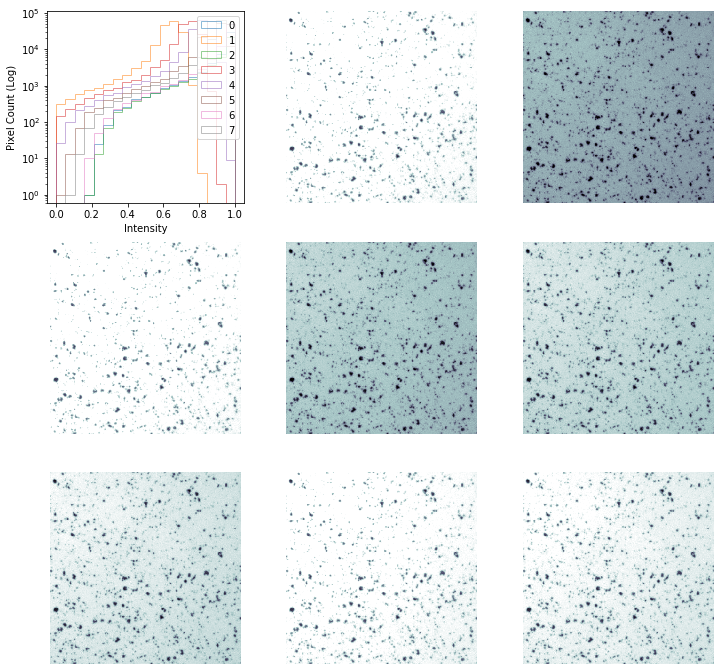

In [1]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
cell_img = imread("../common/figures/Cell_Colony.jpg")/255.0
np.random.seed(2018)
m_cell_imgs = [cell_img+k for k in np.random.uniform(-0.25, 0.25, size = 8)]
fig, m_axs = plt.subplots(3, 3, figsize = (12, 12), dpi = 72)
ax1 = m_axs[0,0]
for i, (c_ax, c_img) in enumerate(zip(m_axs.flatten()[1:], m_cell_imgs)):
    ax1.hist(c_img.ravel(), np.linspace(0, 1, 20), 
             label = '{}'.format(i), alpha = 0.5, histtype = 'step')
    c_ax.imshow(c_img, cmap = 'bone', vmin = 0, vmax = 1)
    c_ax.axis('off')
ax1.set_yscale('log', nonposy = 'clip')
ax1.set_ylabel('Pixel Count (Log)')
ax1.set_xlabel('Intensity')
ax1.legend();

A constant threshold of 0.6 for the different illuminations

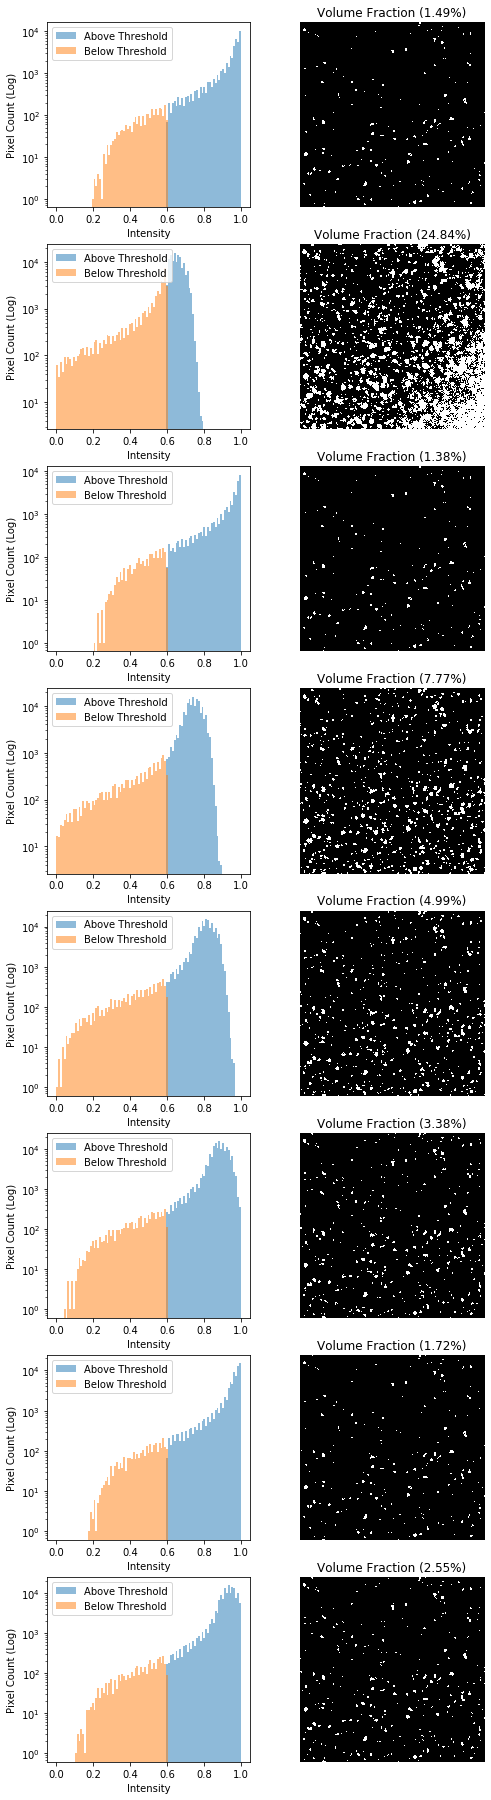

In [2]:
fig, m_axs = plt.subplots(len(m_cell_imgs), 2, 
                          figsize = (4*2, 4*len(m_cell_imgs)), 
                          dpi = 72)
THRESH_VAL = 0.6
for i, ((ax1, ax2), c_img) in enumerate(zip(m_axs, 
                                   m_cell_imgs)):
    ax1.hist(c_img.ravel()[c_img.ravel()>THRESH_VAL], 
             np.linspace(0, 1, 100), 
             label = 'Above Threshold', 
             alpha = 0.5)
    ax1.hist(c_img.ravel()[c_img.ravel()<THRESH_VAL], 
             np.linspace(0, 1, 100), 
             label = 'Below Threshold', 
             alpha = 0.5)
    ax1.set_yscale('log', nonposy = 'clip')
    ax1.set_ylabel('Pixel Count (Log)')
    ax1.set_xlabel('Intensity')
    ax1.legend()
    ax2.imshow(c_img<THRESH_VAL, 
               cmap = 'bone', 
               vmin = 0, vmax = 1)
    ax2.set_title('Volume Fraction (%2.2f%%)' % (100*np.mean(c_img.ravel()<THRESH_VAL)))
    ax2.axis('off')

# Where segmentation fails: Canaliculi

![Bone Slice](ext-figures/bonegfiltslice.png)

### Here is a bone slice

1. Find the larger cellular structures (osteocyte lacunae)
1. Find the small channels which connect them together

***

### The first task 
is easy using a threshold and size criteria (we know how big the cells should be)

### The second 
is much more difficult because the small channels having radii on the same order of the pixel size are obscured by partial volume effects and noise.

# Where segmentation fails: Brain Cortex

![Cortex Image](ext-figures/cortex_mask.png)

- The cortex is barely visible to the human eye
- Tiny structures hint at where cortex is located

*** 

- A simple threshold is insufficient to finding the cortical structures
- Other filtering techniques are unlikely to magicially fix this problem


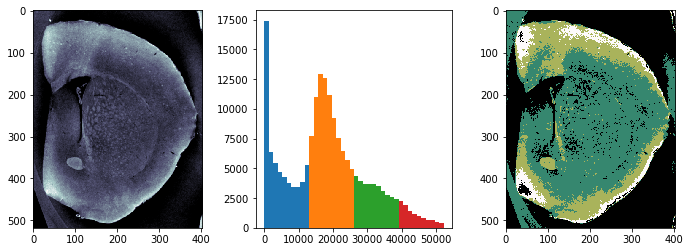

In [3]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
cortex_img = imread("ext-figures/cortex.png")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (12, 4), dpi = 72)
ax1.imshow(cortex_img, cmap = 'bone')
thresh_vals = np.linspace(cortex_img.min(), cortex_img.max(), 4+2)[:-1]
out_img = np.zeros_like(cortex_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (cortex_img>t_start) & (cortex_img<t_end)
    ax2.hist(cortex_img.ravel()[thresh_reg.ravel()])
    out_img[thresh_reg] = i
ax3.imshow(out_img, cmap = 'gist_earth');

# Automated Threshold Selection

![Many possible automated techniques](ext-figures/automaticthresh.png)

***

Given that applying a threshold is such a common and signficant step, there have been many tools developed to automatically (unsupervised) perform it. A particularly important step in setups where images are rarely consistent such as outdoor imaging which has varying lighting (sun, clouds). The methods are based on several basic principles. 


# Automated Methods


### Histogram-based methods
Just like we visually inspect a histogram an algorithm can examine the histogram and find local minimums between two peaks, maximum / minimum entropy and other factors

- Otsu, Isodata, Intermodes, etc

### Image based Methods
These look at the statistics of the thresheld image themselves (like entropy) to estimate the threshold  


### Results-based Methods
These search for a threshold which delivers the desired results in the final objects. For example if you know you have an image of cells and each cell is between 200-10000 pixels the algorithm runs thresholds until the objects are of the desired size
- More specific requirements need to be implemented manually

# Histogram Methods


Taking a typical image of a bone slice, we can examine the variations in calcification density in the image

***

We can see in the histogram that there are two peaks, one at 0 (no absorption / air) and one at 0.5 (stronger absorption / bone)


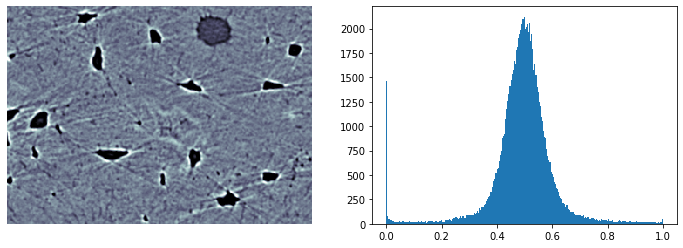

In [4]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
bone_img = imread("ext-figures/bonegfiltslice.png")/255.0
np.random.seed(2018)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (12, 4), dpi = 72)
ax1.imshow(bone_img, cmap = 'bone')
ax1.axis('off')
ax2.hist(bone_img.ravel(), bins=256);

# Histogram Methods

***

### Intermodes
 - Take the point between the two modes (peaks) in the histogram
 
### Otsu

Search and minimize intra-class (within) variance
$$\sigma^2_w(t)=\omega_{bg}(t)\sigma^2_{bg}(t)+\omega_{fg}(t)\sigma^2_{fg}(t)$$

### Isodata

- $\textrm{thresh}= \frac{\max(img)+\min(img)}{2}$
- _while_ the thresh is changing
 - $bg = img<\textrm{thresh}, obj = img>\textrm{thresh}$
 - $\textrm{thresh} = (\textrm{avg}(bg) + \textrm{avg}(obj))/2$

# Try All Thresholds

- [opencv2](https://docs.opencv.org/2.4/doc/tutorials/imgproc/threshold/threshold.html)
- [scikit-image](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html)

There are many methods and they can be complicated to implement yourself. Both Fiji and scikit-image offers many of them as built in functions so you can automatically try all of them on your image


skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


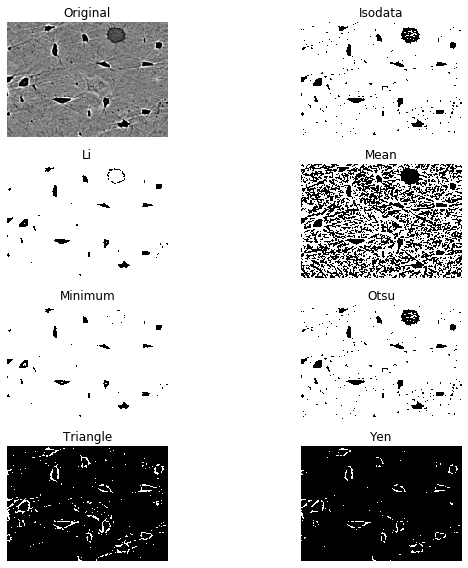

In [5]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
bone_img = imread("ext-figures/bonegfiltslice.png")/255.0

from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(bone_img, figsize=(10, 8), verbose=True)

# Pitfalls

While an incredibly useful tool, there are many potential pitfalls to these automated techniques. 

### Histogram-based

These methods are very sensitive to the distribution of pixels in your image and may work really well on images with equal amounts of each phase but work horribly on images which have very high amounts of one phase compared to the others

### Image-based

These methods are sensitive to noise and a large noise content in the image can change statistics like entropy significantly. 

### Results-based

These methods are inherently biased by the expectations you have. If you want to find objects between 200 and 1000 pixels you will, they just might not be anything meaningful.

# Realistic Approaches for Dealing with these Shortcomings


Imaging science rarely represents the ideal world and will never be 100% perfect. At some point we need to write our master's thesis, defend, or publish a paper. These are approaches for more qualitative assessment we will later cover how to do this a bit more robustly with quantitative approaches

### Model-based

One approach is to try and simulate everything (including noise) as well as possible and to apply these techniques to many realizations of the same image and qualitatively keep track of how many of the results accurately identify your phase or not. Hint: >95% seems to convince most biologists

### Sample-based

Apply the methods to each sample and keep track of which threshold was used for each one. Go back and apply each threshold to each sample in the image and keep track of how many of them are correct enough to be used for further study.

### Worst-case Scenario

Come up with the worst-case scenario (noise, misalignment, etc) and assess how inacceptable the results are. Then try to estimate the quartiles range (75% - 25% of images).

# Hysteresis Thresholding

For some images a single threshold does not work
- large structures are very clearly defined
- smaller structures are difficult to differentiate (see [partial volume effect](http://bit.ly/1mW7kdP))

[ImageJ Source](http://imagejdocu.tudor.lu/doku.php?id=plugin:segmentation:hysteresis_thresholding:start)

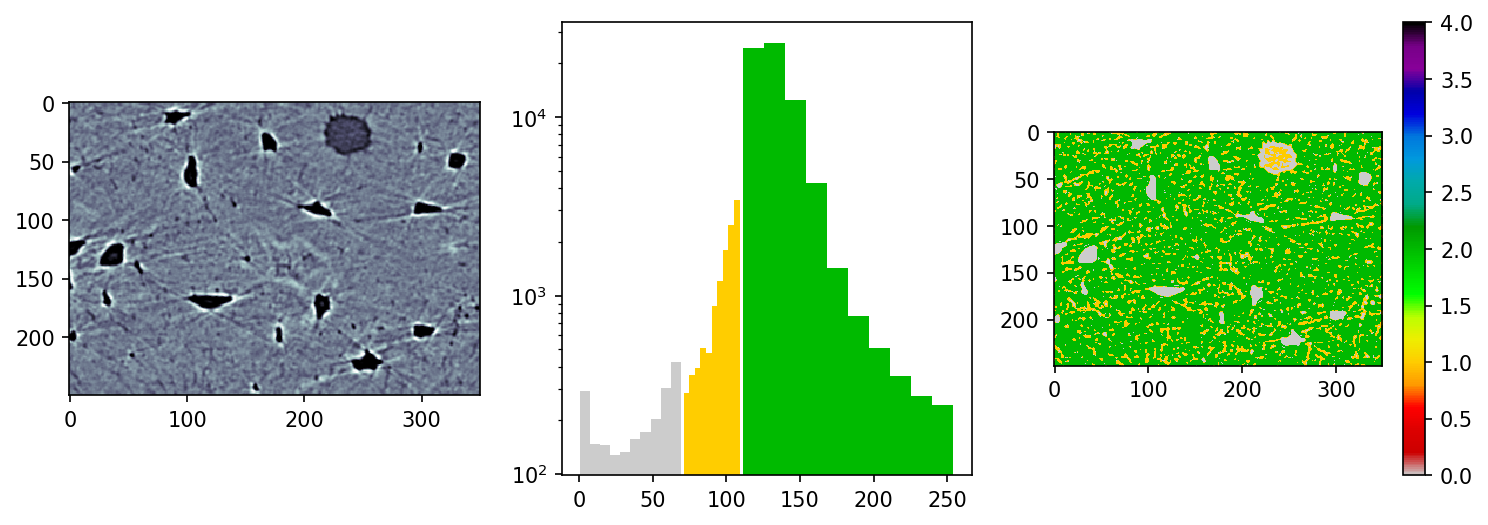

In [6]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
bone_img = imread("ext-figures/bonegfiltslice.png")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (12, 4), dpi = 150)
cmap = plt.cm.nipy_spectral_r
ax1.imshow(bone_img, cmap = 'bone')
thresh_vals = [0, 70, 110, 255]
out_img = np.zeros_like(bone_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (bone_img>t_start) & (bone_img<t_end)
    ax2.hist(bone_img.ravel()[thresh_reg.ravel()], 
             color = cmap(i/(len(thresh_vals))))
    out_img[thresh_reg] = i
ax2.set_yscale("log", nonposy='clip')
th_ax = ax3.imshow(out_img, 
                   cmap = cmap, 
                   vmin = 0, 
                   vmax = len(thresh_vals))
plt.colorbar(th_ax)

# Goldilocks Situation
Here we end up with a goldilocks situation (Mama bear and Papa Bear), one is too low and the other is too high

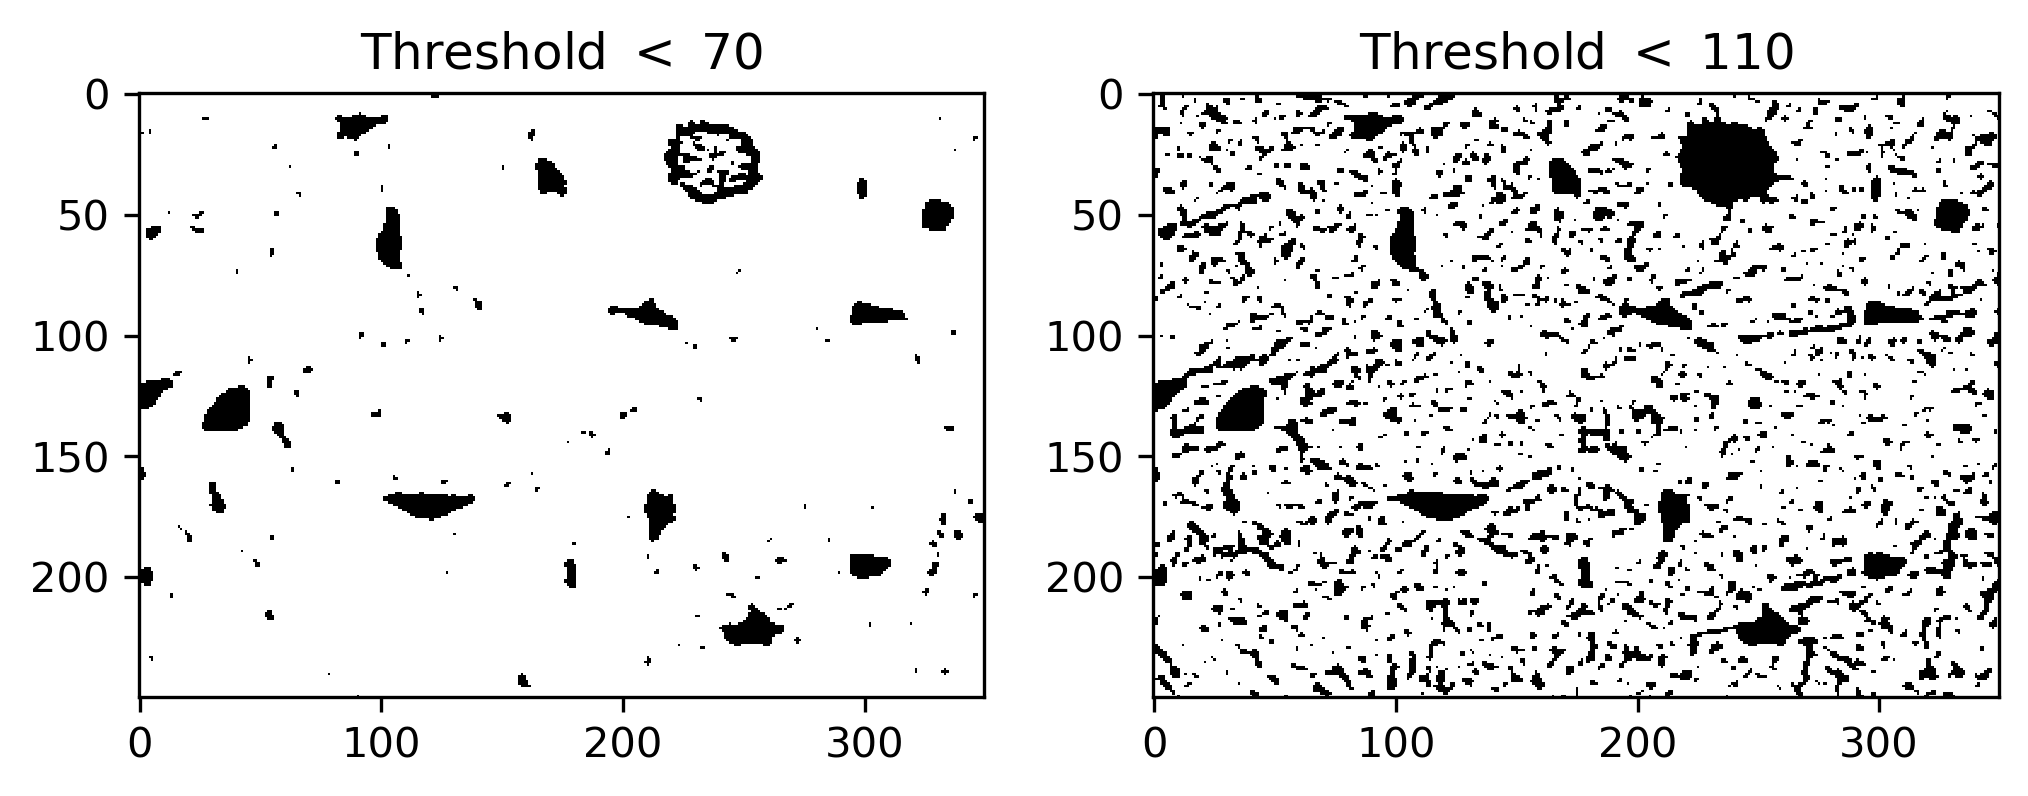

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4), dpi = 300)
ax1.imshow(bone_img<thresh_vals[1], cmap = 'bone_r')
ax1.set_title('Threshold $<$ %d' % (thresh_vals[1]))
ax2.imshow(bone_img<thresh_vals[2], cmap = 'bone_r')
ax2.set_title('Threshold $<$ %d' % (thresh_vals[2]));

# Baby Bear
We can thus follow a process for ending up with a happy medium of the two  

## Hysteresis Thresholding: Reducing Pixels

Now we apply the following steps. 

1. Take the first threshold image with the highest (more strict) threshold
1. Remove the objects which are not cells (too small) using an opening operation.
1. Take a second threshold image with the higher value
1. Combine both threshold images
1. Keep the _between_ pixels which are connected (by looking again at a neighborhood $\mathcal{N}$) to the _air_ voxels and ignore the other ones. This goes back to our original supposition that the smaller structures are connected to the larger structures


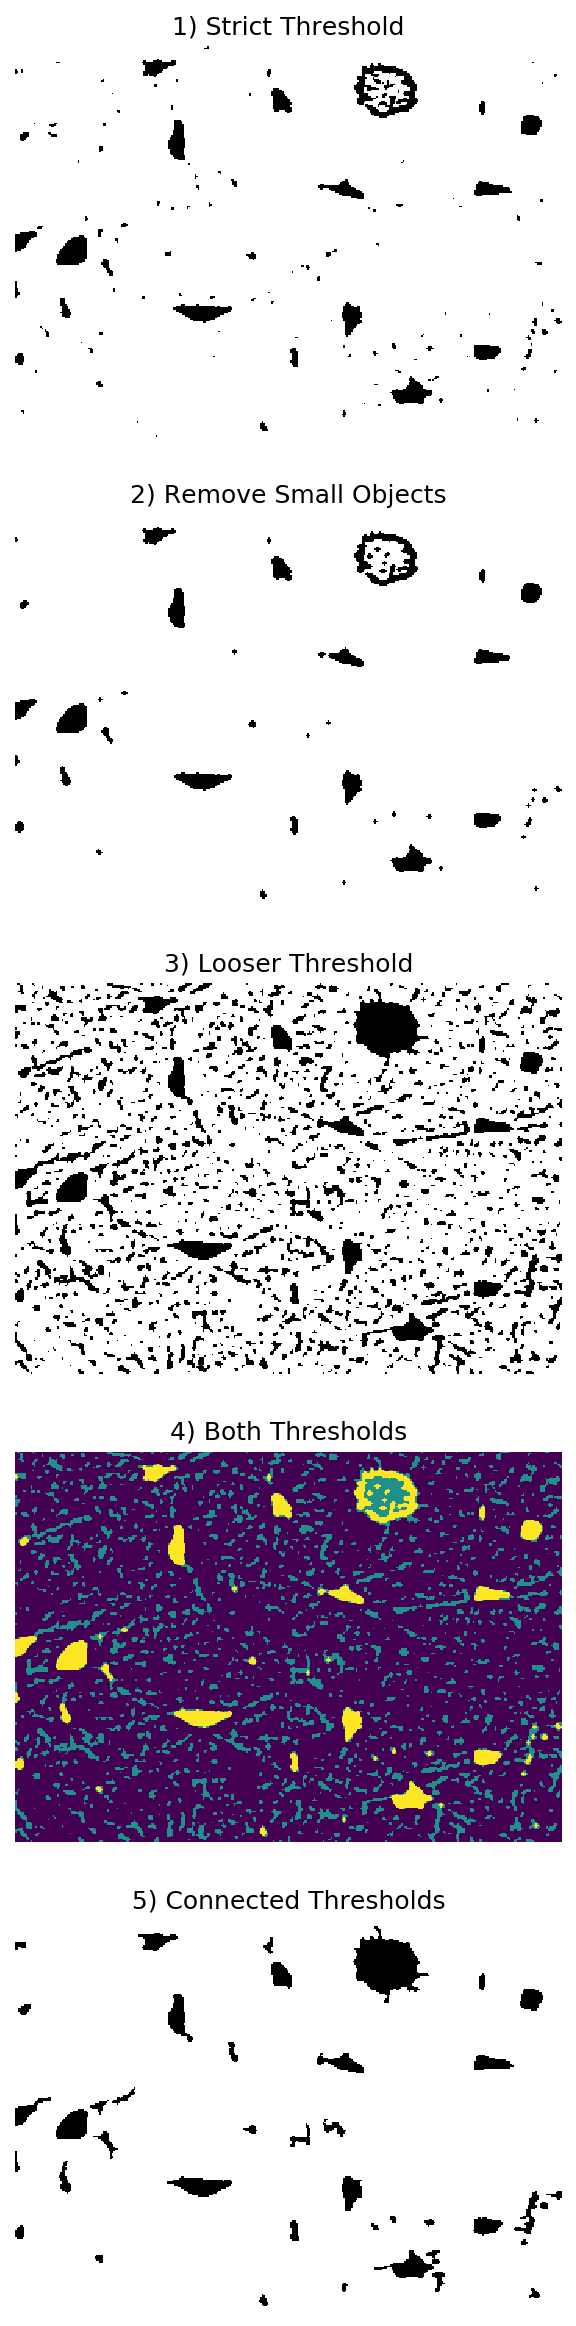

In [8]:
%matplotlib inline
from skimage.morphology import dilation, opening, disk
from collections import OrderedDict
step_list = OrderedDict()
step_list['Strict Threshold'] = bone_img<thresh_vals[1]
step_list['Remove Small Objects'] = opening(step_list['Strict Threshold'], disk(1))
step_list['Looser Threshold'] = bone_img<thresh_vals[2]
step_list['Both Thresholds'] = 1.0*step_list['Looser Threshold'] + 1.0*step_list['Remove Small Objects']
# the tricky part keeping the between images
step_list['Connected Thresholds'] = step_list['Remove Small Objects']
for i in range(10):
    step_list['Connected Thresholds'] = dilation(step_list['Connected Thresholds'] , 
                                                 disk(1.8)) & step_list['Looser Threshold']


fig, ax_steps = plt.subplots(len(step_list), 1,
                             figsize = (6, 4*(len(step_list))), 
                             dpi = 150)

for i, (c_ax, (c_title, c_img)) in enumerate(zip(ax_steps.flatten(), step_list.items()),1):
    c_ax.imshow(c_img, cmap = 'bone_r' if c_img.max()<=1 else 'viridis')
    c_ax.set_title('%d) %s' % (i, c_title))
    c_ax.axis('off')

More Complicated Images
===
As we briefly covered last time, many measurement techniques produce quite rich data. 
- Digital cameras produce 3 channels of color for each pixel (rather than just one intensity)
- MRI produces dozens of pieces of information for every voxel which are used when examining different _contrasts_ in the system.
- Raman-shift imaging produces an entire spectrum for each pixel
- Coherent diffraction techniques produce 2- (sometimes 3) diffraction patterns for each point.
$$ I(x,y) = \hat{f}(x,y) $$

# Feature Vectors

__A pairing between spatial information (position) and some other kind of information (value).__
$$ \vec{x} \rightarrow \vec{f} $$

We are used to seeing images in a grid format where the position indicates the row and column in the grid and the intensity (absorption, reflection, tip deflection, etc) is shown as a different color. We take an example here of text on a page. 

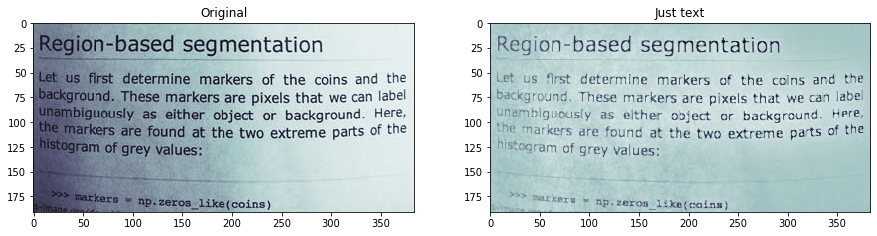

In [9]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import page
import pandas as pd
from skimage.filters import gaussian, median, threshold_triangle
page_image = page()
just_text = median(page_image, np.ones((2,2)))-255*gaussian(page_image, 20.0)

plt.figure(figsize=[15,5])
plt.subplot(1,2,1),plt.imshow(page_image, cmap = 'bone'); plt.title('Original');
plt.subplot(1,2,2),plt.imshow(just_text, cmap = 'bone'); plt.title('Just text');

## Let's create a feature table

In [10]:
xx, yy = np.meshgrid(np.arange(page_image.shape[1]),
           np.arange(page_image.shape[0]))
page_table = pd.DataFrame(dict(x = xx.ravel(), 
                               y = yy.ravel(), 
                               intensity = page_image.ravel(),
                              is_text = just_text.ravel()>0))
page_table.sample(5)

,x,y,intensity,is_text
38169,153,99,174,True
17741,77,46,161,True
38819,35,101,107,True
24130,322,62,234,True
15369,9,40,120,True


## Inspect the features - Intensity vs. IsText

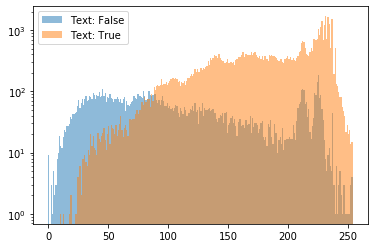

In [11]:
fig, ax1 = plt.subplots(1,1)
for c_cat, c_df in page_table.groupby(['is_text']):
    ax1.hist(c_df['intensity'], 
             np.arange(255), 
             label = 'Text: {}'.format(c_cat), 
             alpha = 0.5) 
ax1.set_yscale("log", nonposy='clip')
ax1.legend();

## What does the ROC curve look like?

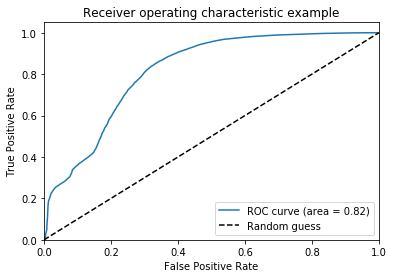

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(page_table['is_text'], page_table['intensity'])
roc_auc = roc_auc_score(page_table['is_text'], page_table['intensity'])
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = {0:0.2})'.format(roc_auc))
ax.plot([0, 1], [0, 1], 'k--',label='Random guess')
ax.set_xlim([0.0, 1.0]), ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right");

# Adding Information
Here we can improve the results by adding information. As we discussed in the second lecture on enhancement, edge-enhancing filters can be very useful for classifying images.

,x,y,intensity,is_text,edges
31063,343,80,234,True,0.101055
17677,13,46,115,True,0.010855
11181,45,29,110,False,-0.041728
55242,330,143,229,True,0.001557
17891,227,46,218,True,0.053318


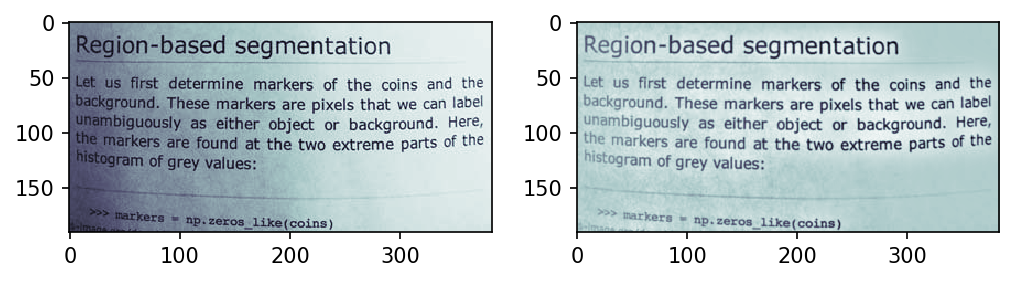

In [13]:
def dog_filter(in_img, sig_1, sig_2):
    return gaussian(page_image, sig_1) - gaussian(page_image, sig_2)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4), dpi = 150)
page_edges = dog_filter(page_image, 0.5, 10)
ax1.imshow(page_image, cmap = 'bone')
ax2.imshow(page_edges, cmap = 'bone')
page_table['edges'] = page_edges.ravel()
page_table.sample(5)

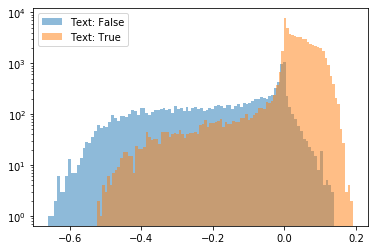

In [14]:
fig, ax1 = plt.subplots(1,1)
for c_cat, c_df in page_table.groupby(['is_text']):
    ax1.hist(c_df['edges'], 
             label = 'Text: {}'.format(c_cat), 
             alpha = 0.5, bins=100)
ax1.set_yscale("log", nonposy='clip')
ax1.legend();

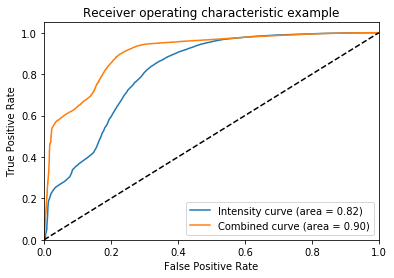

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score 
fpr2, tpr2, _ = roc_curve(page_table['is_text'], 
                          page_table['intensity']/1000.0+page_table['edges'])
roc_auc2 = roc_auc_score(page_table['is_text'], 
                         page_table['intensity']/1000.0+page_table['edges'])
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='Intensity curve (area = %0.2f)' % roc_auc)
ax.plot(fpr2, tpr2, label='Combined curve (area = %0.2f)' % roc_auc2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right");

## Why does the second filter perform better?

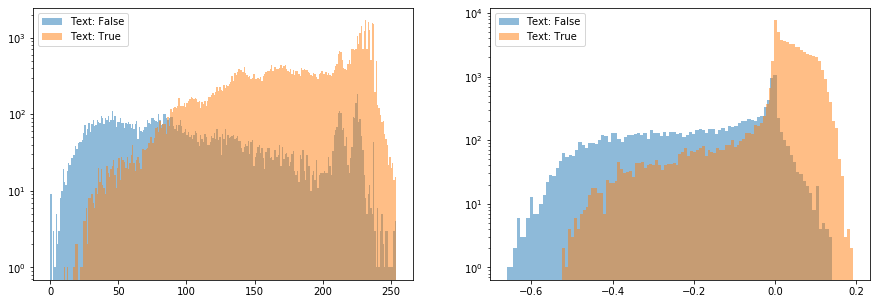

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))
for c_cat, c_df in page_table.groupby(['is_text']):
    ax2.hist(c_df['edges'], 
             label = 'Text: {}'.format(c_cat), 
             alpha = 0.5, bins=100)
ax2.set_yscale("log", nonposy='clip')
ax2.legend();

for c_cat, c_df in page_table.groupby(['is_text']):
    ax1.hist(c_df['intensity'], 
             np.arange(255), 
             label = 'Text: {}'.format(c_cat), 
             alpha = 0.5) 
ax1.set_yscale("log", nonposy='clip')
ax1.legend();

# K-Means Clustering / Classification (Unsupervised)

- Automatic clustering of multidimensional data into groups based on a distance metric
- Fast and scalable to petabytes of data (Google, Facebook, Twitter, etc. use it regularly to classify customers, advertisements, queries)
- __Input__ = feature vectors, distance metric, number of groups
- __Output__ = a classification for each feature vector to a group

# Example
- Distance metric 
$$ D_{ij}=||\vec{v}_i-\vec{v}_j|| $$

- Group Count ($N=2$)


,x,y
190,7.504196,-7.803367
96,8.428999,-7.504711
135,8.877641,-6.836999
73,5.160910,-6.364902
81,10.318225,-3.544903


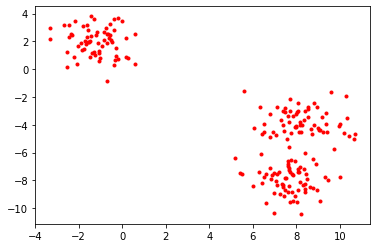

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

test_pts = pd.DataFrame(make_blobs(n_samples=200, random_state=2018)[
                        0], columns=['x', 'y'])
plt.plot(test_pts.x, test_pts.y, 'r.')
test_pts.sample(5)

x         y  group
group                               
0     2    7.089536 -8.347815      0
      133  8.783014 -2.409748      0
      144  7.623933 -6.981879      0
      127  7.835320 -9.493676      0
      83   7.653628 -8.389988      0
1     3   -0.350107  0.682015      1
      10  -1.087616  0.594037      1
      101 -0.693470  1.900714      1
      192 -2.316472  2.448160      1
      29  -2.456372  2.320180      1

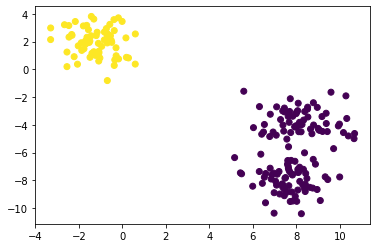

In [18]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2, random_state=2018)
n_grp = km.fit_predict(test_pts)
plt.scatter(test_pts.x, test_pts.y, c=n_grp)
grp_pts = test_pts.copy()
grp_pts['group'] = n_grp
grp_pts.groupby(['group']).apply(lambda x: x.sample(5))

# K-Means Algorithm

We give as an initial parameter the number of groups we want to find and possible a criteria for removing groups that are too similar

1. Randomly create center points (groups) in vector space
1. Assigns group to data point by the “closest” center
1. Recalculate centers from mean point in each group
1. Go back to step 2 until the groups stop changing

*** 

What vector space do we have?
- Sometimes represent physical locations (classify swiss people into cities)
- Can include intensity or color (K-means can be used as a thresholding technique when you give it image intensity as the vector and tell it to find two or more groups)
- Can also include orientation, shape, or in extreme cases full spectra (chemically sensitive imaging)

#### Note:  If you look for N groups you will almost always find N groups with K-Means, whether or not they make any sense


x         y  group
group                                
0     102   8.157207 -8.078576      0
      185   8.613293 -8.506827      0
      94    5.992202 -8.426149      0
1     139  -0.389454  3.579935      1
      8    -0.737558  2.935987      1
      123  -1.765799  1.480105      1
2     91    6.776177 -4.845498      2
      189   8.144676 -3.822473      2
      0     6.406499 -4.677837      2
3     138  10.166384 -4.559689      3
      193  10.677735 -4.628090      3
      157  10.653575 -4.999053      3

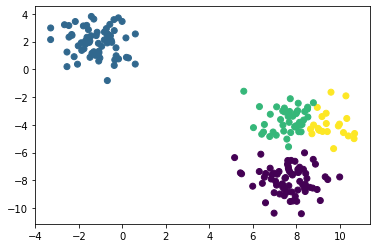

In [19]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=2018)
n_grp = km.fit_predict(test_pts)
plt.scatter(test_pts.x, test_pts.y, c=n_grp)
grp_pts = test_pts.copy()
grp_pts['group'] = n_grp
grp_pts.groupby(['group']).apply(lambda x: x.sample(3))

# K-Means Applied to Cortex Image

In this example we use position and intensity as feature vectors.

,x,y,intensity
18621,126,137,6.015
8830,55,65,18.961
23217,132,171,57.508
7605,45,56,5.810
13164,69,97,18.338


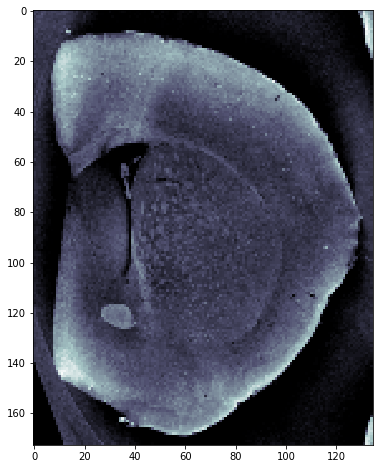

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline
cortex_img = imread("ext-figures/cortex.png")[::3, ::3]/1000.0
np.random.seed(2018)
fig, (ax1) = plt.subplots(1, 1,
                          figsize=(8, 8), dpi=72)
ax1.imshow(cortex_img, cmap='bone')
xx, yy = np.meshgrid(np.arange(cortex_img.shape[1]),
                     np.arange(cortex_img.shape[0]))
cortex_df = pd.DataFrame(dict(x=xx.ravel(),
                              y=yy.ravel(),
                              intensity=cortex_img.ravel()))
cortex_df.sample(5)

## First segmentation attempt

x    y  intensity  group
group                                  
0     19947  102  147      0.000      0
      23325  105  172      1.300      0
      12914   89   95     14.749      0
1     10194   69   75     21.060      1
      4167   117   30      2.163      1
      2292   132   16      0.000      1
2     13783   13  102     24.882      2
      12707   17   94     24.051      2
      12482   62   92     22.727      2
3     9991     1   74     10.478      3
      4633    43   34     28.061      3
      10174   49   75     25.251      3

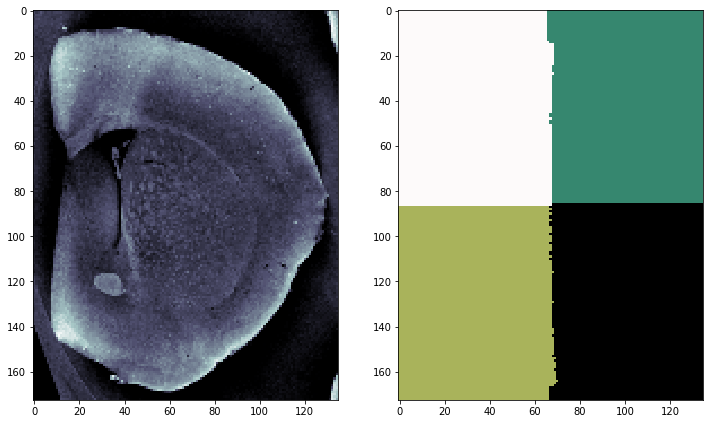

In [21]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=2018)
cortex_df['group'] = km.fit_predict(cortex_df[['x', 'y', 'intensity']].values)

fig, (ax1, ax2) = plt.subplots(1, 2,
                               figsize=(12, 8), dpi=72)
ax1.imshow(cortex_img, cmap='bone')
ax2.imshow(cortex_df['group'].values.reshape(
    cortex_img.shape), cmap='gist_earth')
cortex_df.groupby(['group']).apply(lambda x: x.sample(3))

# Why is the image segmented like this?

# Rescaling components 

Since the distance is currently calculated by $||\vec{v}_i-\vec{v}_j||$ and the values for the position is much larger than the values for the _Intensity_ , _Sobel_ or _Gaussian_ they need to be rescaled so they all fit on the same axis 
$$\vec{v} = \left\{\frac{x}{10}, \frac{y}{10}, \textrm{Intensity}\right\}$$

$N_{clusters}$=4

x     y  intensity  group
group                                    
0     19605   3.0  14.5     33.554      0
      4536    8.1   3.3     28.189      0
      2076    5.1   1.5     41.005      0
1     20771  11.6  15.3      3.194      1
      20944   1.9  15.5      8.133      1
      20251   0.1  15.0      0.000      1
2     17725   4.0  13.1     15.973      2
      16915   4.0  12.5     19.000      2
      12363   7.8   9.1     14.701      2
3     4839   11.4   3.5      0.001      3
      12826   0.1   9.5      3.901      3
      577     3.7   0.4      0.000      3

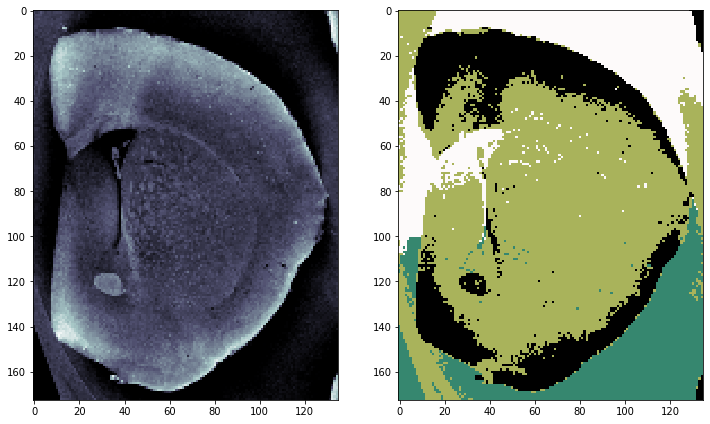

In [22]:
km = KMeans(n_clusters=4, random_state=2018)
scale_cortex_df = cortex_df.copy()
scale_cortex_df.x = scale_cortex_df.x/10
scale_cortex_df.y = scale_cortex_df.y/10
scale_cortex_df['group'] = km.fit_predict(
    scale_cortex_df[['x', 'y', 'intensity']].values)

fig, (ax1, ax2) = plt.subplots(1, 2,
                               figsize=(12, 8), dpi=72)
ax1.imshow(cortex_img, cmap='bone')
ax2.imshow(scale_cortex_df['group'].values.reshape(cortex_img.shape),
           cmap='gist_earth')
scale_cortex_df.groupby(['group']).apply(lambda x: x.sample(3))

## Let's try a different position scaling

$$\vec{v} = \left\{\frac{x}{5}, \frac{y}{5}, \textrm{Intensity}\right\}$$
$N_{clusters}$=5

x     y  intensity  group
group                                    
0     4176   25.2   6.0     12.785      0
      878    13.6   1.2      0.000      0
      3754   21.8   5.4      0.163      0
1     19461   4.2  28.8     44.938      1
      13948   8.6  20.6     32.323      1
      13756  24.2  20.2     29.324      1
2     18287  12.4  27.0     17.979      2
      10894  18.8  16.0     19.776      2
      7307    3.4  10.8     14.900      2
3     23008  11.6  34.0      0.000      3
      15929  26.8  23.4     12.883      3
      21294  19.8  31.4      0.063      3
4     5312    9.4   7.8     23.889      4
      5638   20.6   8.2     37.377      4
      3040   14.0   4.4     39.958      4

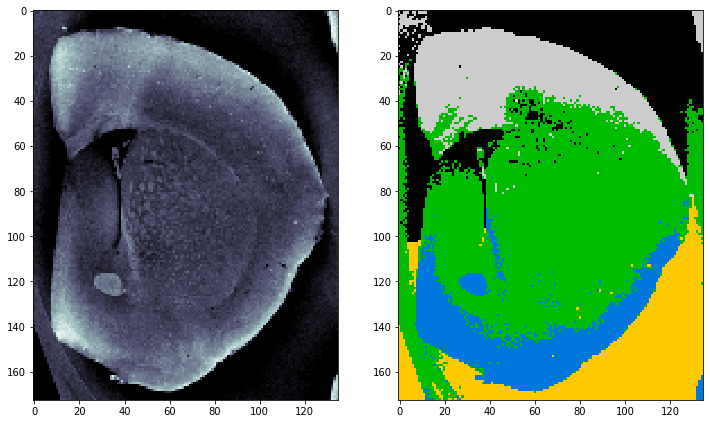

In [23]:
km = KMeans(n_clusters=5, random_state=2019)
scale_cortex_df = cortex_df.copy()
scale_cortex_df.x = scale_cortex_df.x/5
scale_cortex_df.y = scale_cortex_df.y/5
scale_cortex_df['group'] = km.fit_predict(
    scale_cortex_df[['x', 'y', 'intensity']].values)

fig, (ax1, ax2) = plt.subplots(1, 2,
                               figsize=(12, 8), dpi=72)
ax1.imshow(cortex_img, cmap='bone')
ax2.imshow(scale_cortex_df['group'].values.reshape(cortex_img.shape),
           cmap='nipy_spectral')
scale_cortex_df.groupby(['group']).apply(lambda x: x.sample(3))

# Superpixels

An approach for simplifying images by performing a clustering and forming super-pixels from groups of similar pixels. 
https://ivrl.epfl.ch/research/superpixels

<table>
    <tr>
<td><img src="https://www.epfl.ch/labs/ivrl/wp-content/uploads/2018/08/54082_combo.jpg"/></td>
<td><img src="https://www.epfl.ch/labs/ivrl/wp-content/uploads/2018/08/210088_combo.jpg"/></td>
<td><img src="https://www.epfl.ch/labs/ivrl/wp-content/uploads/2018/08/302003_combo.jpg"/></td>
        <tr>
</table>

[DOI](https://doi.org/10.1109/TPAMI.2012.120)

## Why use superpixels

Super pixels
- Drastically reduced data size, 
- Serves as an initial segmentation showing spatially meaningful groups

---
We start with an example of shale with multiple phases
- rock
- clay
- pore

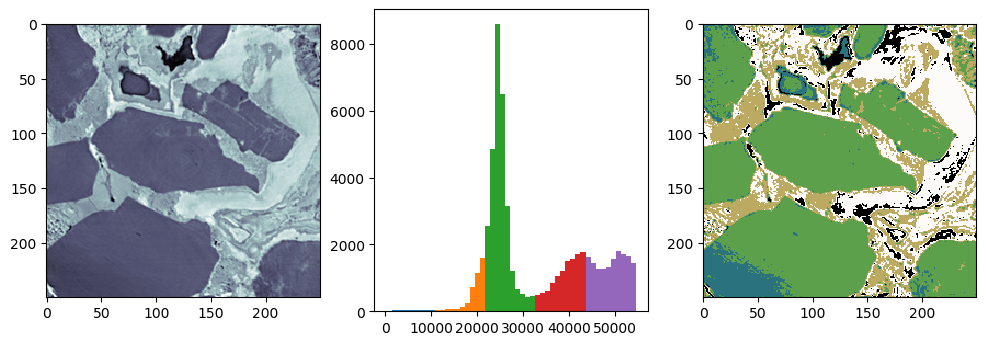

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline
shale_img = imread("../common/figures/shale-slice.tiff")
np.random.seed(2018)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    figsize=(12, 4), dpi=100)
ax1.imshow(shale_img, cmap='bone')
thresh_vals = np.linspace(shale_img.min(), shale_img.max(), 5+2)[:-1]
out_img = np.zeros_like(shale_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (shale_img > t_start) & (shale_img < t_end)
    ax2.hist(shale_img.ravel()[thresh_reg.ravel()])
    out_img[thresh_reg] = i
ax3.imshow(out_img, cmap='gist_earth')

Text(0.5, 1.0, 'Superpixel Overlay')

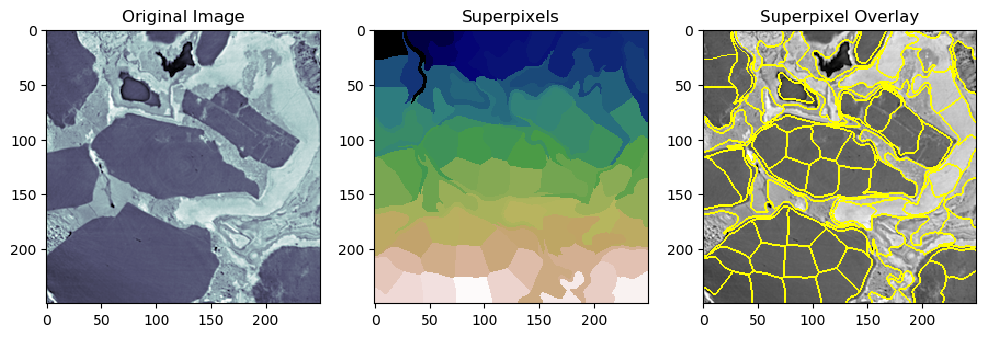

In [25]:
from skimage.segmentation import slic, mark_boundaries
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=100)
shale_segs = slic(shale_img,
                  n_segments=100,
                  compactness=5e-2,
                  sigma=3.0)
ax1.imshow(shale_img, cmap='bone')
ax1.set_title('Original Image')
ax2.imshow(shale_segs, cmap='gist_earth')
ax2.set_title('Superpixels')
ax3.imshow(mark_boundaries(shale_img, shale_segs))
ax3.set_title('Superpixel Overlay')

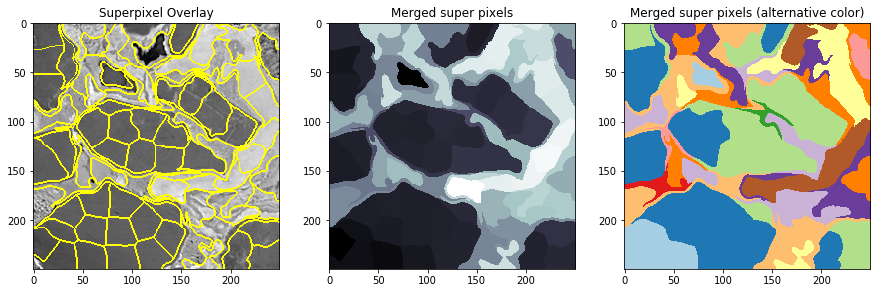

In [26]:
flat_shale_img = shale_img.copy()
for s_idx in np.unique(shale_segs.ravel()):
    flat_shale_img[shale_segs == s_idx] = np.mean(
        flat_shale_img[shale_segs == s_idx])
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(mark_boundaries(shale_img, shale_segs))
ax1.set_title('Superpixel Overlay')
ax2.imshow(flat_shale_img, cmap='bone'); ax2.set_title('Merged super pixels')
ax3.imshow(flat_shale_img, cmap='Paired'); ax3.set_title('Merged super pixels (alternative color)');


Text(0.5, 1.0, 'Superpixel Segmentation')

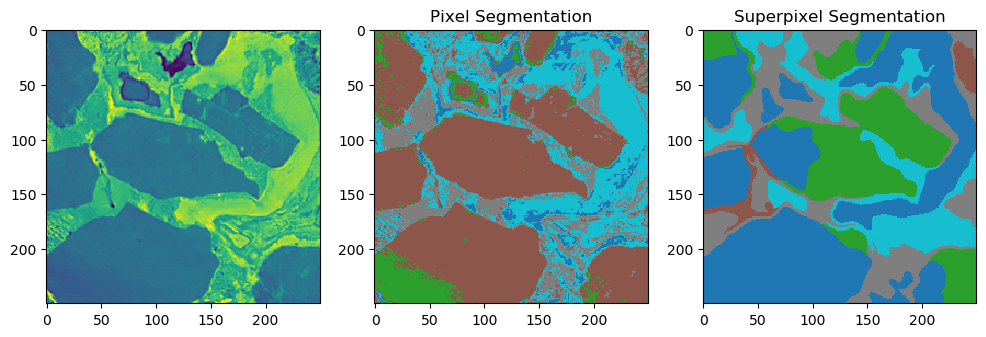

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    figsize=(12, 4), dpi=100)
ax1.imshow(shale_img, cmap='viridis')
thresh_vals = np.linspace(flat_shale_img.min(), flat_shale_img.max(), 5+2)[:-1]
sp_out_img = np.zeros_like(flat_shale_img)
for i, (t_start, t_end) in enumerate(zip(thresh_vals, thresh_vals[1:])):
    thresh_reg = (flat_shale_img > t_start) & (flat_shale_img < t_end)
    sp_out_img[thresh_reg] = i
ax2.imshow(out_img, cmap='tab10')
ax2 .set_title('Pixel Segmentation')
ax3.imshow(sp_out_img, cmap='tab10')
ax3.set_title('Superpixel Segmentation')

# Probabilistic Models of Segmentation

A more general approach is to use a probabilistic model to segmentation. We start with our image $I(\vec{x}) \forall \vec{x}\in \mathbb{R}^N$ and we classify it into two phases $\alpha$ and $\beta$

$$P(\{\vec{x} , I(\vec{x})\}  | \alpha) \propto P(\alpha) + P(I(\vec{x}) | \alpha)+  P(\sum_{x^{\prime} \in \mathcal{N}} I(\vec{x^{\prime}}) |  \alpha)$$
- $P(\{\vec{x} , f(\vec{x})\}  | \alpha)$ the probability a given pixel is in phase $\alpha$ given we know it's position and value (what we are trying to estimate)
- $P(\alpha)$ probability of any pixel in an image being part of the phase (expected volume fraction of that phase)
- $P(I(\vec{x}) | \alpha)$ probability adjustment based on knowing the value of $I$ at the given point (standard threshold)
- $P(f(\vec{x^{\prime}}) |  \alpha)$ are the collective probability adjustments based on knowing the value of a pixels neighbors (very simple version of [Markov Random Field](http://en.wikipedia.org/wiki/Markov_random_field) approaches)